## 4.3 以PyTorch撰寫MNIST

In [1]:
import torch

In [5]:
# 下載手寫數字影像資料MNIST

# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original', data_home=".")  # data_homeは保存先を指定します

# 2019年1月31日修訂
# 上述的程式將發生下列的錯誤
#  [WinError 10060] 連線逾時，無法正確回應，所以無法連線。或是連線的主機未能回應、已建立的連線為失敗連線

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".")  # data_home可指定儲存位置



In [6]:
# 1. 資料的事前處理（分割成影像資料與標籤，再進行標準化處理）

X = mnist.data / 255  # 將0-255標準化為0-1
y = mnist.target

# 2019年1月31日修訂
# MNIST的資料集變更後，標籤無法轉換成數值資料
# 所以利用下列的命令轉換成NumPy陣列的數值型

import numpy as np
y = np.array(y)
y = y.astype(np.int32)


這張影像資料的標籤是5喲


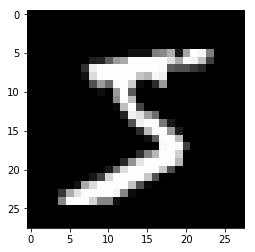

In [7]:
# 顯示第一筆MNIST資料

# 2019年1月31日修訂
# 刪除%matplotlib%之後的空白

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("這張影像資料的標籤是{:.0f}喲".format(y[0]))


In [8]:
# 2.  建立DataLoader

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 分割成訓練資料與測試資料（6:1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 2.2 將NumPy資料轉換成Tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 建立資料與標籤為一組的Dataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 指定資料集的小批次大小與建立Dataloader
# 與Chainer的iterators.SerialIterator類似
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)


In [9]:
# 3.  建置神經網路
# Keras的語法

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)


Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [10]:
# 4.  設定誤差函數與最佳化手法

from torch import optim

# 設定誤差函數
loss_fn = nn.CrossEntropyLoss()  # 變數名稱常使用criterion

# 選擇學習權重之際的最佳化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [11]:
# 5.  設定訓練與推論
# 5-1. 定義單次訓練的內容
# 沒有與Chainer的training.Trainer()對應的部分


def train(epoch):
    model.train()  # 將神經網路切換成訓練模式

    # 從DataLoader逐步取出以小批次為單位的資料再進行計算
    for data, targets in loader_train:
      
        optimizer.zero_grad()  # 將計算所得的梯度結果重設為0
        outputs = model(data)  # input輸入值，算出輸出值
        loss = loss_fn(outputs, targets)  # 計算輸出值與訓練資料的正確解答的誤差
        loss.backward()  # 以反向傳播演算法計算誤差
        optimizer.step()  # 以反向傳播演算法的值更新權重

    print("epoch{}：結束\n".format(epoch))


In [12]:
# 5. 設定訓練與推論
# 5-2. 定義單次推論的內容
# 沒有與Chainer的training.Trainer()對應的部分


def test():
    model.eval()  # 將神經網路切換成推論模式
    correct = 0

    # 從DataLoader逐步取出以小批次為單位的資料再進行計算
    with torch.no_grad():  # 推論階段不需要微分的計算
        for data, targets in loader_test:

            outputs = model(data)  # input輸入值，算出輸出值

            # 進行推論
            _, predicted = torch.max(outputs.data, 1)  # 取得機率最高的標籤
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 與正確解答一致的話遞增1

    # 輸出正確解答率
    data_num = len(loader_test.dataset)  # 資料總數
    print('\n測試資料的正確解答率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [13]:
# 在不經學習之下，以測試資料進行推論
test()



測試資料的正確解答率: 872/10000 (8%)



In [14]:
# 6. 執行學習與推論
for epoch in range(3):
    train(epoch)

test()


epoch0：結束

epoch1：結束

epoch2：結束


測試資料的正確解答率: 9571/10000 (95%)



預測結果是2
這張影像資料的正確解答標籤是2喲


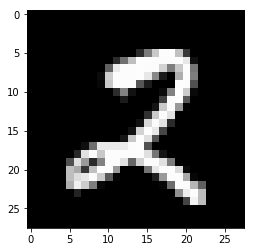

In [15]:
# 例如要推論第2018張影像資料

index = 2018

model.eval()  # 將神經網路切換成推論模式
data = X_test[index]
output = model(data)  # input輸入值，求得輸出值
_, predicted = torch.max(output.data, 0)  # 求得機率最高的標籤

print("預測結果是{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("這張影像資料的正確解答標籤是{:.0f}喲".format(y_test[index]))


In [12]:
#-----------------------------------------------

In [16]:
# 3. 建置神經網路
# 神經網路的設定（Chainer的語法）
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  # 與Chainer不同的是，None代表不接受
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        # 依照輸入值x調整forward的運算方法
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output


model = Net(n_in=28*28*1, n_mid=100, n_out=10)  # 產生神經網路的物件
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
